### Install dependencies

In [ ]:
# Install required libs
# !python -m pip install --user tensorboard numpy matplotlib ipython ipykernel jupyter segmentation-models-pytorch albumentations opencv-python tqdm natsort gdown scikit-image

### MHP dataset link

In [ ]:
# Download LV-MHP-v2 
# https://drive.google.com/file/d/1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn/

# Voc will be downloaded later

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Helper function for data visualization


In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from natsort import natsorted
from functools import reduce
from skimage import io

def verify_image(img_file):
    try:
        img = io.imread(img_file)
    except:
        return False
    return True

def get_mask_fp_infos(mask_fp):
    id, num_persons, curr_person = os.path.basename(mask_fp).split(".")[0].split("_")
    return int(id), int(num_persons), int(curr_person)


### MHP Dataloader


In [ ]:
class Dataset(BaseDataset):
    """MHP v2 Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASS_LABELS = [
        "Background", "Cap/hat","Helmet", "Face", "Hair", "Left-arm", "Right-arm", "Left-hand", "Right-hand", "Protector", 
        "Bikini/bra", "Jacket/windbreaker/hoodie", "Tee-shirt", "Polo-shirt", "Sweater", "Singlet", "Torso-skin", 
        "Pants", "Shorts/swim-shorts", "Skirt", "Stockings", "Socks", "Left-boot", "Right-boot", "Left-shoe",
        "Right-shoe", "Left-highheel", "Right-highheel", "Left-sandal", "Right-sandal", "Left-leg", "Right-leg",
        "Left-foot", "Right-foot", "Coat", "Dress", "Robe", "Jumpsuit" , "Other-full-body-clothes" , "Headwear",
        "Backpack", "Ball", "Bats", "Belt", "Bottle", "Carrybag", "Cases", "Sunglasses", "Eyewear", "Glove",
        "Scarf", "Umbrella"," Wallet/purse", "Watch", "Wristband", "Tie"," Other-accessary", 
        "Other-upper-body-clothes", "Other-lower-body-clothes"
        ]

    def __init__(self, size, classes=None, augmentation=None, preprocessing=None):
        images_dir = "data/LV-MHP-v2/train/images/"
        masks_dir = "data/LV-MHP-v2/train/parsing_annos/"
        self.images_ids = natsorted(os.listdir(images_dir))[0:size]
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.images_ids]
        self.masks_ids = natsorted(os.listdir(masks_dir))
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.masks_ids]
    
        # convert str names to class values on masks
        self.class_indices = [self.CLASS_LABELS.index(cls) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        if verify_image(self.images_fps[i]):
            # read image
            image = cv2.imread(self.images_fps[i])
        else:
            image = cv2.imread(self.images_fps[i-1])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # combine mask files
        mask_files_per_image = []
        for el in self.masks_fps:
            mask_id = int(get_mask_fp_infos(el)[0]) 
            img_id = int(self.images_ids[i].split(".")[0])
            if(mask_id == img_id):
                mask_files_per_image.append(el)
        
        mask_files = []
        for file in mask_files_per_image:
            mask_file = cv2.imread(file)
            if mask_file.ndim == 3:
                mask_file = cv2.cvtColor(mask_file, cv2.COLOR_BGR2RGB)
                mask_file = mask_file[:,:,0]
                mask_files.append(mask_file)
        # Create union of all mask files
        combined_file = reduce(lambda array_a, array_b: array_a | array_b, mask_files)

         # extract certain classes from mask (e.g. cars)
        masks = [(combined_file == label_index) for label_index in self.class_indices]
        mask = reduce(lambda array_a, array_b: array_a | array_b, masks)
        if self.class_indices == [0]:
            mask = np.invert(mask)
        mask = mask[:,:, np.newaxis]
        mask = mask.astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask, combined_file=combined_file)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_ids)

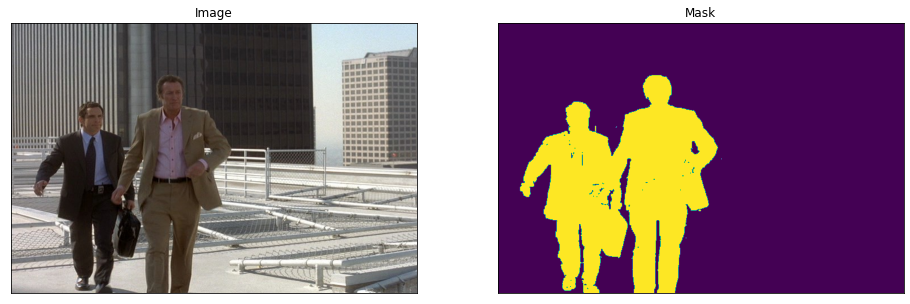

In [ ]:
dataset = Dataset(size=2000, classes=['Background'])

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

## VOC Dataloader

In [ ]:
from torchvision.datasets import VOCSegmentation
import albumentations as albu

In [ ]:
VOC_CLASSES = [
    "background", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", 
    "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
    "person", "potted plant", "sheep", "sofa", "train", "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128], 
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], 
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128],
]

In [ ]:
class TransformedVOC(VOCSegmentation):
    # def __init__(self, augmentation=None, preprocessing=None, classes=VOC_CLASSES):
    def __init__(self, root, image_set, download=False,  augmentation=None, preprocessing=None):
        super(TransformedVOC, self).__init__(root=root, image_set=image_set, download=download,)
        # self.classes = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.remove_list = []

    # @staticmethod
    # def _convert_to_segmentation_mask(mask, labels):
    #     height, width = mask.shape[:2]
    #     segmentation_mask = np.zeros((height, width, len(labels)), dtype=np.float32)
    #     for idx, label in enumerate(labels):
    #         label_idx = VOC_CLASSES.index(label)
    #         label_color = VOC_COLORMAP[label_idx]
    #         segmentation_mask[:, :, idx] = np.all(mask == label_color, axis=-1).astype(float)
    #     return segmentation_mask

    def __getitem__(self, idx):
        # image = cv2.imread(self.images[idx])
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # mask = cv2.imread(self.masks[idx])
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # mask = self._convert_to_segmentation_mask(mask, self.classes)

        image, mask = super(TransformedVOC, self).__getitem__(idx)
        image = np.array(image)
        mask = np.array(mask)
        mask = mask.astype('float')
        mask = np.where(mask==15, 1., 0.)
        uniques = np.unique(mask)
        if 1. not in uniques:
            self.remove_list.append(idx)
        mask = mask[:,:,np.newaxis]

         # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

### VOC Visualisation

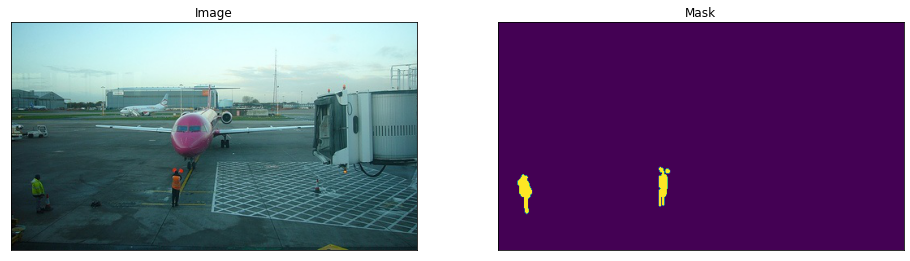

In [ ]:
dataset = TransformedVOC(root="data/", image_set="trainval")

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

# VOC Orig Dataloader

In [ ]:
class VOCOrig(VOCSegmentation):
    def __init__(self, root, image_set,  augmentation=None, preprocessing=None, classes=VOC_CLASSES):
        super(VOCOrig, self).__init__(root, image_set = image_set)
        self.classes = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    @staticmethod
    def _convert_to_segmentation_mask(mask, labels):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(labels)), dtype=np.float32)
        for idx, label in enumerate(labels):
            label_idx = VOC_CLASSES.index(label)
            label_color = VOC_COLORMAP[label_idx]
            segmentation_mask[:, :, idx] = np.all(mask == label_color, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask, self.classes)

         # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

### VOC Orig Vis

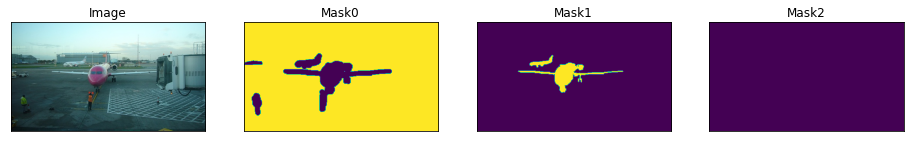

In [ ]:
dataset = VOCOrig(root="data/", image_set="trainval")

example_image, example_mask = dataset[0] # get some sample

    
visualize(
    image=example_image, 
    mask0=example_mask[:,:,0],
    mask1=example_mask[:,:,1],
    mask2=example_mask[:,:,2],
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

In [ ]:
import numbers

IMG_SIZE = 128

#### MHP Augmentations

In [ ]:
class HeadCrop(object):
    """Crops the given PIL Image around head region.

    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        offset (int): Offset in y-axis
    """

    def __init__(self, size, offset):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.offset = offset

    def __call__(self, **kwargs):
        image = kwargs.get('image', None)
        mask = kwargs.get('mask', None)
        combined_file = kwargs.get('combined_file', None)
        

        # Extract head region
        head_masks = [(combined_file == label_index) for label_index in [4, 3, 2, 39]]
        head_mask = reduce(lambda array_a, array_b: array_a | array_b, head_masks)
        # Get coordinates of first head pixel
        first_head = np.where(head_mask == True)
        row, col = first_head[0][0], first_head[1][0]
        x_min = max(0, col - self.size[1] // 2)
        y_min = max(0, row + self.offset - self.size[0] // 2)
        x_max = x_min + self.size[1]
        y_max = y_min + self.size[0]
        cropped_image = image[y_min:y_max, x_min:x_max]
        cropped_mask = mask[y_min:y_max, x_min:x_max]
        return {"image": cropped_image, "mask": cropped_mask}

    def __repr__(self):
        return self.__class__.__name__ + '()'

class CustomResize(object):
    def __init__(self, size):
        self.size = size
    
    def __call__(self, **kwargs):
        image = kwargs.get('image', None)
        mask = kwargs.get('mask', None)
        image = cv2.resize(image, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, (self.size, self.size), interpolation=cv2.INTER_NEAREST)
        return {"image": image, "mask": mask}


In [ ]:
def get_training_augmentation():
    train_transform = [
        HeadCrop((200, 400), 100),
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        HeadCrop((200, 400), 100),
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(test_transform)



#### MHP Augmented Visualisation

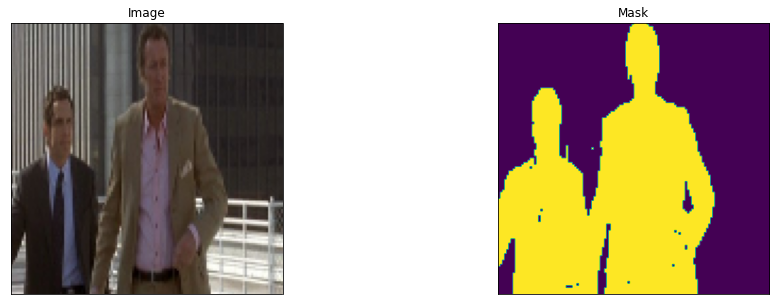

In [ ]:
dataset = Dataset(
    augmentation=get_training_augmentation(),
    size=2000, 
    classes=['Background'])

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

#### VOC Augmentations

In [ ]:
def get_training_augmentation_voc():
    train_transform = [
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation_voc():
    test_transform = [
        albu.Resize(IMG_SIZE,IMG_SIZE)
    ]
    return albu.Compose(test_transform)

#### VOC Augmented Visualisation

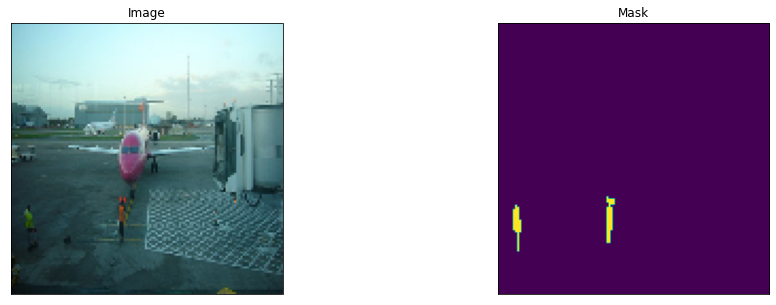

In [ ]:
dataset = TransformedVOC(root="data/", image_set="trainval", download=False, augmentation=get_training_augmentation_voc())

example_image, example_mask = dataset[0] # get some sample

visualize(
    image=example_image, 
    mask=example_mask,
)

### VOC Orig Augmented Vis

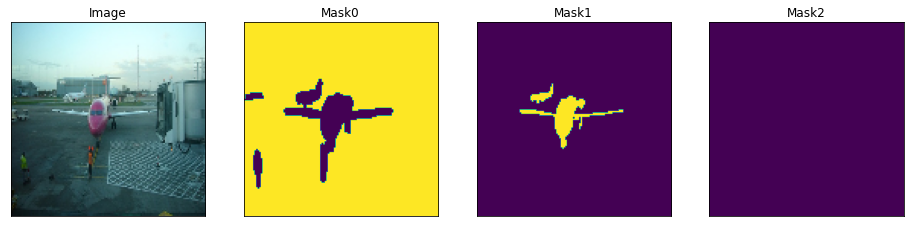

In [ ]:
train_dataset_voc_orig = VOCOrig(
    root="data/", 
    image_set="train", 
    augmentation=get_training_augmentation_voc(), 
    )

example_image, example_mask = train_dataset_voc_orig[0] # get some sample


visualize(
    image=example_image, 
    mask0=example_mask[:,:,0],
    mask1=example_mask[:,:,1],
    mask2=example_mask[:,:,2],
)

#### Preprocessing

In [ ]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Create models

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
ENCODER = 'timm-mobilenetv3_small_minimal_100'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['Background']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model1 = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# create segmentation model with pretrained encoder
model2 = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# create segmentation model with pretrained encoder
model3 = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=21, 
    activation=ACTIVATION,
)



### Load MHP Dataset

In [ ]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

dataset = Dataset(
    size=1464+1449, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn), 
    classes=CLASSES,
)

dataset_size = len(dataset)
train_size =  int(np.floor(dataset_size*0.5))
valid_size = dataset_size - train_size

train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)


### Load VOC Dataset

In [ ]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset_voc = TransformedVOC(
    root="data/", 
    image_set="train", 
    augmentation=get_training_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    )


    
valid_dataset_voc = TransformedVOC(
    root="data/", 
    image_set="val", 
    augmentation=get_validation_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn))

train_loader_voc = DataLoader(train_dataset_voc, batch_size=8, shuffle=True, num_workers=0)
valid_loader_voc = DataLoader(valid_dataset_voc, batch_size=1, shuffle=False, num_workers=0)


### Load VOC orig

In [ ]:
train_dataset_voc_orig = VOCOrig(
    root="data/", 
    image_set="train", 
    augmentation=get_training_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn)
    )

valid_dataset_voc_orig = VOCOrig(
    root="data/", 
    image_set="val", 
    augmentation=get_validation_augmentation_voc(), 
    preprocessing=get_preprocessing(preprocessing_fn)
    )


train_loader_voc_orig = DataLoader(train_dataset_voc_orig, batch_size=8, shuffle=True, num_workers=0)
valid_loader_voc_orig = DataLoader(valid_dataset_voc_orig, batch_size=1, shuffle=False, num_workers=0)


## Training

### Defining a loss function

In [ ]:
import torch.nn as nn

class FocalTverskyLoss(nn.Module):
    __name__ = 'focal_tversky_loss'

    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.7, beta=0.3, gamma=0.75):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        # inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()  
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
        
        return FocalTversky


In [ ]:
# loss = smp.utils.losses.DiceLoss()

ALPHA = 0.7
BETA = 0.3
GAMMA = 0.75

loss1 = FocalTverskyLoss()
loss2 = FocalTverskyLoss()
loss3 = FocalTverskyLoss()

metrics1 = [
    smp.utils.metrics.IoU(threshold=0.5),
]
metrics2 = [
    smp.utils.metrics.IoU(threshold=0.5),
]
metrics3 = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer1 = torch.optim.Adam([ 
    dict(params=model1.parameters(), lr=0.0001),
])

optimizer2 = torch.optim.Adam([ 
    dict(params=model2.parameters(), lr=0.0001),
])

optimizer3 = torch.optim.Adam([ 
    dict(params=model3.parameters(), lr=0.0001),
])


### Create epoch runners 

In [ ]:

# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model1, 
    loss=loss1, 
    metrics=metrics1, 
    optimizer=optimizer1,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model1, 
    loss=loss1, 
    metrics=metrics1, 
    device=DEVICE,
    verbose=True,
)

train_epoch_voc = smp.utils.train.TrainEpoch(
    model2, 
    loss=loss2, 
    metrics=metrics2, 
    optimizer=optimizer2,
    device=DEVICE,
    verbose=True,
)

valid_epoch_voc = smp.utils.train.ValidEpoch(
    model2, 
    loss=loss2, 
    metrics=metrics2, 
    device=DEVICE,
    verbose=True,
)

train_epoch_voc_orig = smp.utils.train.TrainEpoch(
    model3, 
    loss=loss3, 
    metrics=metrics3, 
    optimizer=optimizer3,
    device=DEVICE,
    verbose=True,
)

valid_epoch_voc_orig = smp.utils.train.ValidEpoch(
    model3, 
    loss=loss3, 
    metrics=metrics3, 
    device=DEVICE,
    verbose=True,
)

### Tensorboard


In [ ]:
from torch.utils.tensorboard import SummaryWriter


In [42]:
max_score = 0
max_score_voc = 0
max_score_voc_orig = 0

writer = SummaryWriter()
log_dir_name = writer.get_logdir()

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    print("MHP")
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    writer.add_scalar('MHP/Loss/train', train_logs["focal_tversky_loss"], i)
    writer.add_scalar('MHP/Loss/valid', valid_logs["focal_tversky_loss"], i)
    writer.add_scalar('MHP/IoU/train', train_logs["iou_score"], i)
    writer.add_scalar('MHP/IoU/valid', valid_logs["iou_score"], i)

    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model1, log_dir_name + '/best_model.pth')
        print('MHP Model saved!')
    
    print("VOC")
    train_logs_voc = train_epoch_voc.run(train_loader_voc)
    valid_logs_voc = valid_epoch_voc.run(valid_loader_voc)

    writer.add_scalar('VOC/Loss/train', train_logs_voc["focal_tversky_loss"], i)
    writer.add_scalar('VOC/Loss/valid', valid_logs_voc["focal_tversky_loss"], i)
    writer.add_scalar('VOC/IoU/train', train_logs_voc["iou_score"], i)
    writer.add_scalar('VOC/IoU/valid', valid_logs_voc["iou_score"], i)

    if max_score_voc < valid_logs_voc['iou_score']:
        max_score_voc = valid_logs_voc['iou_score']
        torch.save(model2, log_dir_name + '/best_model_voc.pth')
        print('VOC Model saved!')
   
    print("VOC Orig")
    train_logs_voc_orig = train_epoch_voc_orig.run(train_loader_voc_orig)
    valid_logs_voc_orig = valid_epoch_voc_orig.run(valid_loader_voc_orig)

    writer.add_scalar('VOC_Orig/Loss/train', train_logs_voc_orig["focal_tversky_loss"], i)
    writer.add_scalar('VOC_Orig/Loss/valid', valid_logs_voc_orig["focal_tversky_loss"], i)
    writer.add_scalar('VOC_Orig/IoU/train', train_logs_voc_orig["iou_score"], i)
    writer.add_scalar('VOC_Orig/IoU/valid', valid_logs_voc_orig["iou_score"], i)

    if max_score_voc_orig < valid_logs_voc_orig['iou_score']:
        max_score_voc_orig = valid_logs_voc_orig['iou_score']
        torch.save(model3, log_dir_name + '/best_model_voc_orig.pth')
        print('VOC Orig Model saved!')
    
    
    if i == 25:
        optimizer1.param_groups[0]['lr'] = 1e-5
        optimizer2.param_groups[0]['lr'] = 1e-5
        optimizer3.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        


Epoch: 0
MHP
train:   0%|          | 0/182 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Test best saved model

In [32]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')
best_model_voc = torch.load('./best_model_voc.pth')
best_model_voc_orig = torch.load('./best_model_voc_orig.pth')

In [33]:
# create test dataset
test_dataset = Dataset(
    size=1000,
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)


In [34]:
class CustomValidEpoch(smp.utils.train.ValidEpoch):
    def __init__(self, model, loss, metrics, device=DEVICE, verbose=True):
         super().__init__(
            model=model,
            loss=loss,
            metrics=metrics,
            device=device,
        )

    def batch_update(self, x, y):
        with torch.no_grad():
            prediction = self.model.forward(x)
            argmax = torch.argmax(prediction, dim=1)
            prediction = torch.where(argmax==15, 1, 0)
            prediction = prediction[:, np.newaxis, :, :]
            loss = self.loss(prediction, y)
        return loss, prediction

In [51]:

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss1,
    metrics=metrics1,
    device=DEVICE,
)
print("MHP")
logs = test_epoch.run(test_dataloader)

writer.add_scalar('MHP/Loss/test', logs["focal_tversky_loss"])
writer.add_scalar('MHP/IoU/test', logs["iou_score"])

test_epoch_voc = smp.utils.train.ValidEpoch(
    model=best_model_voc,
    loss=loss2,
    metrics=metrics2,
    device=DEVICE,
)
print("VOC")
logs_voc = test_epoch_voc.run(test_dataloader)

writer.add_scalar('MHP/Loss/test', logs_voc["focal_tversky_loss"])
writer.add_scalar('MHP/IoU/test', logs_voc["iou_score"])

test_epoch_voc_orig = CustomValidEpoch(
    model=best_model_voc_orig,
    loss=loss3,
    metrics=metrics3,
    device=DEVICE,
)
print("VOC Orig")
logs_voc_orig = test_epoch_voc_orig.run(test_dataloader)

writer.add_scalar('MHP/Loss/test', logs_voc_orig["focal_tversky_loss"])
writer.add_scalar('MHP/IoU/test', logs_voc_orig["iou_score"])


MHP
valid:   1%|▏         | 14/1000 [00:02<02:26,  6.74it/s, focal_tversky_loss - 0.1719, iou_score - 0.8156]


KeyboardInterrupt: 

### Inference Time Measurement
https://deci.ai/resources/blog/measure-inference-time-deep-neural-networks/

In [39]:
from timeit import default_timer as timer
from tqdm import tqdm

In [54]:
def measureInferenceTime(model, dataset):
    model.to(DEVICE)
    repetitions= 100
    total_time = 0
    with torch.no_grad():
        for rep in tqdm(range(repetitions)):
            n = np.random.choice(len(dataset))
            image, _ = dataset[n]
            x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
            start = timer()
            _ = best_model.predict(x_tensor)
            end = timer()
            elapsed_time = (end-start)/1000
            total_time += elapsed_time
    inference_time = total_time/repetitions
    print('Average inference time:', inference_time)
    return inference_time


In [53]:
# MHP Model 
time = measureInferenceTime(best_model, test_dataset)
writer.add_scalar('MHP/time', time)
# VOC Model
time = measureInferenceTime(best_model_voc, test_dataset)
writer.add_scalar('VOC/time', time)
# VOC Orig Model
time = measureInferenceTime(best_model_voc_orig, test_dataset)
writer.add_scalar('VOC_Orig/time', time)


100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


Average inference time: 2.4065775700000812e-05


100%|██████████| 10/10 [00:02<00:00,  3.87it/s]


Average inference time: 2.9504332500005154e-05


100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

Average inference time: 2.6694829500002017e-05


## Visualize predictions

In [50]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    size=1000,
    classes=CLASSES,
)

UsageError: Line magic function `%tensorboard` not found.


(3, 128, 128)


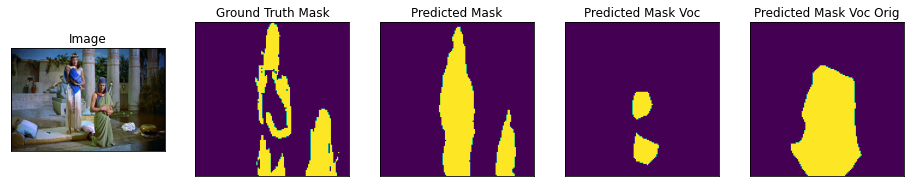

(3, 128, 128)


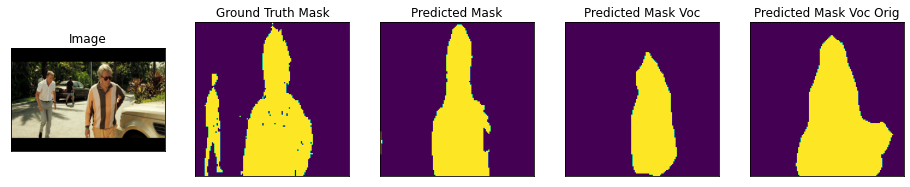

(3, 128, 128)


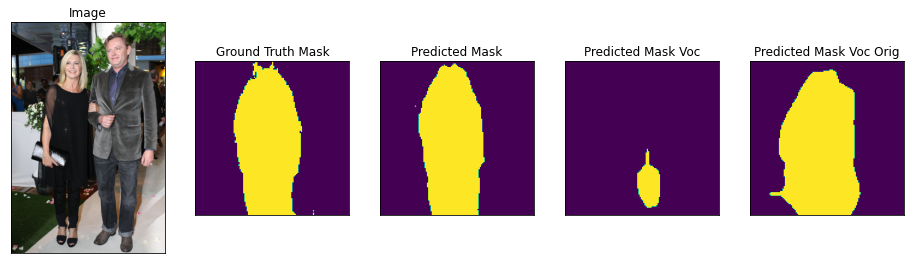

(3, 128, 128)


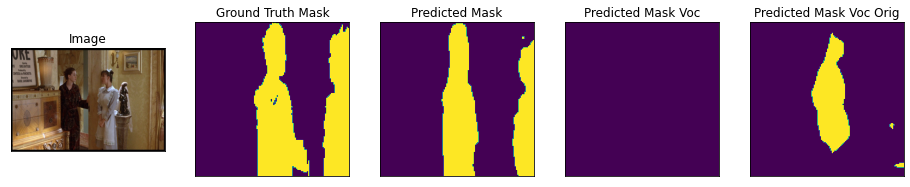

(3, 128, 128)


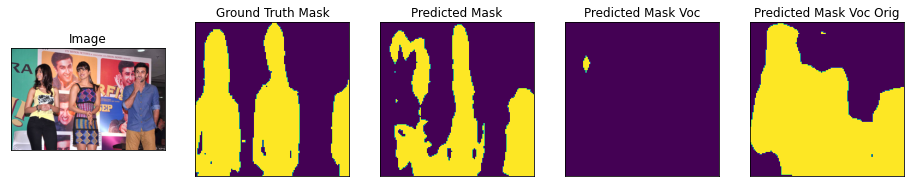

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    pr_mask_voc = best_model_voc.predict(x_tensor)
    pr_mask_voc = (pr_mask_voc.squeeze().cpu().numpy().round())

    pr_mask_voc_orig = best_model_voc_orig.predict(x_tensor)
    argmax = torch.argmax(pr_mask_voc_orig, dim=1)
    pr_mask_voc_orig = torch.where(argmax==15, 1, 0)
    pr_mask_voc_orig = pr_mask_voc_orig[:, np.newaxis, :, :]
    pr_mask_voc_orig = (pr_mask_voc_orig.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask,
        predicted_mask_voc=pr_mask_voc,
        predicted_mask_voc_orig=pr_mask_voc_orig,
    )